In [6]:
import os
from typing import Dict, List, Tuple

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output

In [3]:
env = gym.make('FrozenLake-v1', render_mode='rgb_array')
# env = gym.make('CartPole-v1', render_mode='rgb_array')
# device = torch.device(
#     "cuda" if torch.cuda.is_available() else "cpu"
# )
device = torch.device("cpu")

In [13]:
class QNetwork(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        super(QNetwork, self).__init__()
        '''注意网络的定义为Q(s,a;w),隐变量为w,输入为状态s,输出为当前状态s下所有可能动作A的最大未来收益'''
        self.layers = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128), 
            nn.ReLU(), 
            nn.Linear(128, out_dim)
        )
#         self.layers.
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''前向推理实现'''
        return self.layers(x)

In [46]:
obs_dim = env.observation_space.n
action_dim = env.action_space.n

# 构建两个Q函数，其中Q为，Q_target为
Q = QNetwork(obs_dim, action_dim).to(device)
# Q_target = QNetwork(obs_dim, action_dim).to(device)
# Q_target.load_state_dict(Q.state_dict())
# Q_target.eval()

#
optimizer = optim.Adam(Q.parameters(), lr=0.001)

In [47]:
def convert_state(state):
    init_state = torch.tensor([state])
    return F.one_hot(init_state, num_classes = obs_dim).numpy()[0].tolist()

epsilon = 0.2
def select_action(state, explore = True):
    # 选择动作，有0.2的概率进行随机探索
    if explore and np.random.random() < epsilon:
        return np.random.randint(0, action_dim)
    else:
        # 有0.8的概率从当前训练的Q函数中，预测所有可能动作的Q值
        cur_state = convert_state(state)
        q_value = Q(torch.FloatTensor(cur_state).to(device))
        action = q_value.argmax().detach().cpu().item()
        return action

# 
# state, _ = env.reset()
# for i in range(10):
#     v = select_action(state)
#     print(type(v), v)
#     next_state, reward, done, _, _ = env.step(v)

convert_state(3)

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [49]:
gamma = 0.98
seed = 3

scores = []
losses = []
steps = []
#假设要跑100幂
epoch = 5000
while True:
    if epoch <= 0:
        break
    
    epoch -= 1
    score = 0
    '''使用如下方式时，state的类型是list，否则是一个array'''
    state, _ = env.reset()
    
    step = 0
    while True:
        '''这里代理选择一个动作来执行'''
        action = select_action(state)
        '''得到下一个状态,构成(s,a,r,s')'''
        next_state, reward, done, truncated, _ = env.step(action)
        
        score += reward
        step += 1
        
        next_s = convert_state(next_state)
        # 这里要使用Q的动作策略
        next_a = select_action(next_state, False)
        
        cur_state = convert_state(state)
        '''
        这里可以计算Q_*(s, A)，以及Q_*(s', A),然后用TD算法，逼近Q_*
        '''
        index_tensor = torch.tensor([action])
        q_value = Q(torch.FloatTensor(cur_state).to(device)).gather(0, index_tensor)
        
        next_index_tensor = torch.tensor([next_a])
        next_q_value = Q(torch.FloatTensor(next_s).to(device)).gather(0, next_index_tensor)
        mask = 1 - done
        target = reward + gamma * next_q_value * mask
        
#         print(q_value, target, q_value.shape, target.shape)
        loss = F.smooth_l1_loss(q_value, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if done:
            scores.append(score)
            steps.append(step)
            break
            
        state = next_state
        
        if epsilon < 0.05:
            epsilon = 0.05
        else:
            epsilon *= 0.98


In [51]:
cur_state = convert_state(6)
print(Q(torch.FloatTensor(cur_state).to(device)))

tensor([0.4020, 0.2541, 0.3112, 0.3234], grad_fn=<AddBackward0>)


In [53]:
# 观察效果
def test():
    dvideo_env = gym.wrappers.RecordVideo(env, video_folder='.')
    state, _ = dvideo_env.reset(seed=seed)
    done = False
    score = 0
    step = 0
    while not done:
        action = select_action(state, False)
        next_state, reward, done, truncated, _ = dvideo_env.step(action)

        state = next_state
        score += reward
        step +=1

    print("score: ", score, "step:", step)
    dvideo_env.close()
    
test()

/home/ubuntu/anaconda3/lib/python3.7/site-packages/gymnasium/wrappers/record_video.py:88: UserWarning: WARN: Overwriting existing videos at /media/ubuntu/8b2f607c-117a-47e9-b82e-caf4eeeabeca/temp/test/reinforce_learning/rainbow folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  f"Overwriting existing videos at {self.video_folder} folder "


Moviepy - Building video /media/ubuntu/8b2f607c-117a-47e9-b82e-caf4eeeabeca/temp/test/reinforce_learning/rainbow/rl-video-episode-0.mp4.
Moviepy - Writing video /media/ubuntu/8b2f607c-117a-47e9-b82e-caf4eeeabeca/temp/test/reinforce_learning/rainbow/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /media/ubuntu/8b2f607c-117a-47e9-b82e-caf4eeeabeca/temp/test/reinforce_learning/rainbow/rl-video-episode-0.mp4
score:  1.0 step: 44


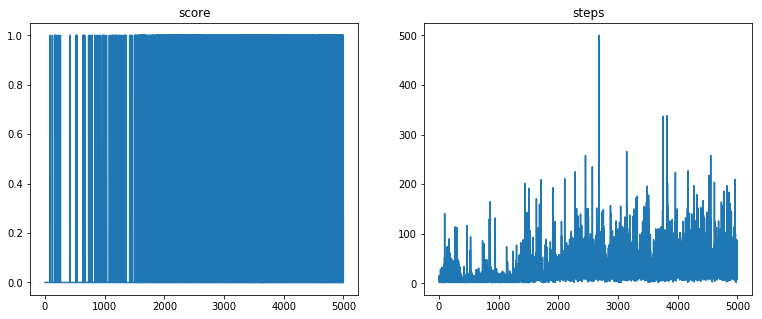

In [52]:
# 观察曲线
plt.figure(figsize=(20, 5))
plt.subplot(131)
# plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
plt.title('score')
plt.plot(scores)
plt.subplot(132)
plt.title('steps')
plt.plot(steps)
# plt.subplot(133)
# plt.title('epsilons')
# plt.plot(epsilons)
plt.show()